## Обработка естественного языка

Как мы говорили ранее, нейросети хорошо справляются с извлечением паттернов из данных. Естественный язык также можно рассматривать как последовательности токенов, и искать паттерны в этих последовательностях.

Для начала установим некоторые библиотеки:

In [ ]:
%pip install gguf bitsandbytes langchain langchain_community yandexcloud gigachat yandex-speechkit

INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9 MB/s eta 0:00

### Пример: анализ отзывов

Рассмотрим пример - у нас есть отзывы посетителей о московских вокзалах, и нам нужно построить на основе этих отзывов какую-то статистику и сделать выводы.

Чтобы код ниже работал достаточно быстро - рекомендуется включить GPU (T4) Runtime в Google Colab, выбрав **Среда выполнения -> Выбрать среду выполнения**

Посмотрим на данные:

In [ ]:
!wget https://github.com/shwars/ai-for-creatives/raw/refs/heads/main/data/rail_reviews.zip
!unzip rail_reviews

--2026-01-19 10:23:53--  https://github.com/shwars/ai-for-creatives/raw/refs/heads/main/data/rail_reviews.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shwars/ai-for-creatives/refs/heads/main/data/rail_reviews.zip [following]
--2026-01-19 10:23:53--  https://raw.githubusercontent.com/shwars/ai-for-creatives/refs/heads/main/data/rail_reviews.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 390394 (381K) [application/zip]
Saving to: ‘rail_reviews.zip’

rail_reviews.zip    100%[===================>] 381.24K  --.-KB/s    in 0.03s   

2026-01-19 10:23:54 (14.6 MB/s) - ‘rail_reviews.zip’ save

In [ ]:
!head reviews_Belorussky_railway_station.json

[
    {
        "id": 1251,
        "dislike": 1,
        "like": 10,
        "review_text": "Очень красивое место, вежливый персонал.\nЕздила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.",
        "author": "Александра Подгайская",
        "review_rating": 5,
        "datetime": "2024-01-12T16:53:33.611Z"
    },


Для удобства, загрузим все отзывы в табличку:

In [ ]:
import pandas as pd
import json
import os
from glob import glob

res = []
for fn in glob('*.json'):
    j = json.load(open(fn))
    for x in j:
        x['station'] = fn.split('_')[1]
    res.extend(j)

df = pd.DataFrame(res)
df

id  dislike  like                                        review_text  \
0     1251        1    10  Очень красивое место, вежливый персонал.\nЕзди...   
1     1252        0     5  Расположен очень удобное, строятся новые пути ...   
2     1253        2     7  Очень уютный и удобный вокзал. Мне он очень нр...   
3     1254        1     5  Красивое здание , очень удобно расположено в т...   
4     1255        2     7  С появление новых веток и маршрутов все стало ...   
...    ...      ...   ...                                                ...   
2264  2266        0     1  Отличный вокзал. Новый, современный, прям из в...   
2265  2267        1     0  Бывал недавно там )) очень вкусная кухня \nКла...   
2266  2268        0     0  Отличный и красивый вокзал. Чистые туалеты и б...   
2267  2269        3    10  Это не вокзал , а скорее узловая станция или п...   
2268  2270        0     3  Очень приятный новый вокзал! Разобраться сложн...   

                     author  review_rating                  datetime  \
0     Александра Подгайская              5  2024-01-12T16:53:33.611Z   
1           Пользователь Э.              5  2023-11-10T21:33:56.176Z   
2                       Н И              5  2023-08-25T14:27:29.327Z   
3            Liliya Zugrova              5  2023-11-27T11:50:16.388Z   
4           Татьяна Цымлова              5  2023-11-25T06:43:16.558Z   
...                     ...            ...                       ...   
2264           Анна Елагина              5  2024-02-02T04:55:15.074Z   
2265                Дмитрий              5  2023-11-12T14:21:47.541Z   
2266  Валентина Архимановна              5  2024-01-31T10:53:36.364Z   
2267      Владислав Баранов              2  2023-12-06T12:03:14.107Z   
2268      Наталья Байбакова              5  2023-12-24T13:10:29.484Z   

         station  
0     Belorussky  
1     Belorussky  
2     Belorussky  
3     Belorussky  
4     Belorussky  
...          ...  
2264   Vostochny  
2265   Vostochny  
2266   Vostochny  
2267   Vostochny  
2268   Vostochny  

[2269 rows x 8 columns]

Самая очевидная статистика - по позитивным и негативным отзывам. Для этого найдём на [HuggingFace](http://huggingface.co) какую-нибудь модель, которая может делать анализ тональности русского текста (sentiment analysis). Например, [rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews), натренированную как раз на отзывах. Код для использования модели возьмём со странички модели:

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', return_dict=True)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

Посмотрим, как модель работает:

In [ ]:
predict([
    'Ничего так вокзал, обычный...',
    'Обожаю этот вокзал, там такие симпатичные бомжи!',
    'Ненавижу это вокзал, поезда всегда опаздывают минимум на 20 минут'])

array([0, 1, 2])

В документации на модель написано, что выходные значиния такие:
* 0: NEUTRAL
* 1: POSITIVE
* 2: NEGATIVE

Чтобы модель работала быстрее, нам нужно будет внести небольшие изменения в код, чтобы она работала на GPU:


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted

Пройдёмся по всем отзывам и вычислим их позитивность/негативность, но для удобства негативный отзыв будем помечать как -1:

In [ ]:
from tqdm.auto import tqdm
import numpy as np

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)

df['sentiment'] = pd.Series(res).apply(lambda x: -1 if x==2 else x)

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
df

id  dislike  like                                        review_text  \
0     1251        1    10  Очень красивое место, вежливый персонал.\nЕзди...   
1     1252        0     5  Расположен очень удобное, строятся новые пути ...   
2     1253        2     7  Очень уютный и удобный вокзал. Мне он очень нр...   
3     1254        1     5  Красивое здание , очень удобно расположено в т...   
4     1255        2     7  С появление новых веток и маршрутов все стало ...   
...    ...      ...   ...                                                ...   
2264  2266        0     1  Отличный вокзал. Новый, современный, прям из в...   
2265  2267        1     0  Бывал недавно там )) очень вкусная кухня \nКла...   
2266  2268        0     0  Отличный и красивый вокзал. Чистые туалеты и б...   
2267  2269        3    10  Это не вокзал , а скорее узловая станция или п...   
2268  2270        0     3  Очень приятный новый вокзал! Разобраться сложн...   

                     author  review_rating                  datetime  \
0     Александра Подгайская              5  2024-01-12T16:53:33.611Z   
1           Пользователь Э.              5  2023-11-10T21:33:56.176Z   
2                       Н И              5  2023-08-25T14:27:29.327Z   
3            Liliya Zugrova              5  2023-11-27T11:50:16.388Z   
4           Татьяна Цымлова              5  2023-11-25T06:43:16.558Z   
...                     ...            ...                       ...   
2264           Анна Елагина              5  2024-02-02T04:55:15.074Z   
2265                Дмитрий              5  2023-11-12T14:21:47.541Z   
2266  Валентина Архимановна              5  2024-01-31T10:53:36.364Z   
2267      Владислав Баранов              2  2023-12-06T12:03:14.107Z   
2268      Наталья Байбакова              5  2023-12-24T13:10:29.484Z   

         station  sentiment  
0     Belorussky          1  
1     Belorussky          1  
2     Belorussky          1  
3     Belorussky          1  
4     Belorussky          0  
...          ...        ...  
2264   Vostochny          1  
2265   Vostochny          1  
2266   Vostochny          1  
2267   Vostochny          0  
2268   Vostochny          1  

[2269 rows x 9 columns]

Посчитаем количество положительных и отрицательных отзывов по вокзалам:

In [ ]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()

df.groupby('station').agg({'sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

sentiment                     review_text
                 mean count_pos count_neg       count
station                                              
Belorussky   0.680000        36         2          50
Kazan        0.647619       143         7         210
Kursky       0.395000       277        40         600
Kyiv         0.599332       385        26         599
Paveletsky   0.540000        27         0          50
Rizhsky      0.560000       374        38         600
Savyolovsky  0.480000        29         5          50
Vostochny    0.618182        71         3         110

## Фундаментальные модели

Для выполнения той же задачи (анализ текста) мы можем использовать **больщую языковую модель** (LLM). Такие модели также называются **фундаментальными**, потому что они могут выполнять множество разных действий в зависимости от запроса.

Найти подходящую языковую модель можно на [HuggingFace](https://huggingface.co). Для примера рассмотрим модель [T-Lite](https://huggingface.co/t-tech). Код для генерации текста возьмём со страницы модели и добавим одну строчку `load_in_8bit = True`, чтобы модель поместилась в память GPU.

> Перед загрузкой надо очистить память GPU, чтобы модель туда поместилась

In [ ]:
import gc
tokenizer = None
model = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
torch.manual_seed(42)

model_name = "t-tech/T-lite-it-1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
quant_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto",
    quantization_config=quant_config
)

prompt = "Напиши стих про машинное обучение"
messages = [
    {"role": "system", "content": "Ты T-lite, виртуальный ассистент в Т-Технологии. Твоя задача - быть полезным диалоговым ассистентом."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=256
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


В мире данных, где алгоритмы царят,  
Машинное обученье – искусство и наука.  
Оно учится, как человек, но без сна,  
На больших данных строит свой план.

Входные данные – как семена в земле,  
Обучение – как дождь и свет весны.  
С каждым шагом модель становится мудрее,  
Решает задачи, что раньше казались труднее.

От классификации до регрессии,  
Машинное обученье – как маяк в ночи.  
Предсказывает, анализирует, учится,  
Ведет нас к будущему, что ярче и шире.

Но помни, в этом пути важен баланс:  
Этика и безопасность – не забывай.  
Чтобы технологии служили нам, а не против,  
Машинное обученье – это светлый путь вперед.


На вход модели подаётся история переписки, состоящая из сообщений трех видов:
* Системное сообщение `system` - идёт первым и задаёт общий тон и установки модели
* Сообщение от пользователя `user`
* Ответ модели `assistant`

Вот пример переписки:
```json
messages = [
    {"role": "system", "content": "Ты T-lite, виртуальный ассистент в Т-Технологии. Твоя задача - быть полезным диалоговым ассистентом."},
    {"role": "user", "content": prompt}
]
```
Для наших целей опишем функцию `generate`, которая будет формировать ответ модели на заданный промпт и системный промпт.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

def generate(prompt,system_prompt="Ты - умный редактор текстов"):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt}
  ]
  return invoke(messages)

def invoke(messages):
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256
  )
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


Теперь используем эту модель для определения позитивности или негативности отзыва. Поскольку модель работает не очень быстро, обработаем только три первых отзыва.

In [ ]:
prompt = """
Посмотри на отзыв ниже в тройных обратных кавычках и выдай уровень его позитивности от 0 до 5.
Выдай в качестве ответа только одно число. Вот отзыв: ```{}```
"""
for x in df['review_text'].iloc[0:3]:
  print(x)
  res = generate(prompt.format(x))
  print(f"--> {res}")

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.
--> 4
Расположен очень удобное, строятся новые пути и оптимизируются пересадочные узлы. В здании вокзала есть бургер Кинг, несколько бюджетных кафешек и ларьков. Много валидаторов, а пересадка между диаметров так и вовсе без них - для удобства. Туалеты только мрак, но в БК нормально :)
--> 4
Очень уютный и удобный вокзал. Мне он очень нравится! В шаговой доступности метро, удобная высадка и посадка в такси. Не нужно бегать по этажам: проходишь досмотр, небольшой вестибюль- и вот уже платформы. Современный навес надёжно защищает перрон от дождя и снега. На платформе недалеко от табло есть туалеты. Электронное табло расположено удобно. Ну и кроме удобств здесь красиво! Отдельного внимания безусловно заслуживает памятник "Прощан

Но с помощью фундаментальной модели мы можем не только определять позитивность/негативность текста, но и выделять из него ключевые положительные и отрицательные моменты!

In [ ]:
prompt = """
Посмотри на отзыв ниже в тройных обратных кавычках и выдай краткий список позитивных и негативных
моментов, упомянутых в отзыве. Ответ верни в формате JSON.
Выдай в качестве ответа только результат. Вот отзыв: ```{}```
"""
for x in df['review_text'].iloc[0:3]:
  print(x)
  res = generate(prompt.format(x))
  print(f"--> {res}")

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.
--> ```json
{
  "positive": [
    "Очень красивое место",
    "Вежливый персонал",
    "Комфортно ехать на поезде",
    "Белье чистое",
    "Тепло",
    "Можно с животными",
    "Дают горячий чай в постель",
    "Квалифицированные сотрудники позаботились о комфорте"
  ],
  "negative": []
}
```
Расположен очень удобное, строятся новые пути и оптимизируются пересадочные узлы. В здании вокзала есть бургер Кинг, несколько бюджетных кафешек и ларьков. Много валидаторов, а пересадка между диаметров так и вовсе без них - для удобства. Туалеты только мрак, но в БК нормально :)
--> ```json
{
  "positive": [
    "удобное расположение",
    "строительство новых путей",
    "оптимизация пересадочных узлов",
    "наличие бургер Кинга",
  

Но мы видим, что на ограниченных ресурсах облака модель работает не очень быстро. Для запуска более крупных моделей лучше использовать облачные сервисы.

## Языковые модели в облаке

Рассмотрим пару примеров использования языковых моделей. Для разнообразия будем использовать YandexGPT или GigaChat (к нему проще получить доступ). Для работы с GigaChat понадобится код, который можно получить [по инструкции](https://developers.sber.ru/docs/ru/gigachat/quickstart/ind-using-api).

> Для работы с Yandex GPT потребуется доступ в [Yandex Cloud](http://yandex.cloud). Вы можете оформить пробный период и получить грант в размере 4000 руб. на облачные услуги, или получить ключи у преподавателя на интересные проекты. Далее в облаке нужно [создать сервисный аккаунт](https://yandex.cloud/ru/docs/iam/operations/sa/create) (с ролью ai.user) и получить к нему [API-ключ доступа](https://yandex.cloud/ru/docs/iam/operations/api-key/create). Этот API-ключ и идентификатор каталога облака folder_id нужно сохранить в ключах вашего Google Colab

Есть два вида моделей:
- Те, которые могут только дополнять текст
- **Диалоговые модели**, которые могут поддерживать диалог.

Мы как раз воспользуемся диалоговыми моделями.

In [ ]:
from langchain_community.chat_models.gigachat import GigaChat
from langchain_community.chat_models.yandex import ChatYandexGPT
from google.colab import userdata

gigachat_creds = userdata.get('gigachat_creds')
folder_id = userdata.get('folder_id')
api_key = userdata.get('api_key')

GC = GigaChat(
    credentials=gigachat_creds,
    scope="GIGACHAT_API_PERS",
    model="GigaChat",
    streaming=False,
    verify_ssl_certs=False,
)

YGPT = ChatYandexGPT(folder_id=folder_id, api_key=api_key, model_name='yandexgpt')

GPT = YGPT # используем Yandex GPT, замените на GC для гигачат

/tmp/ipython-input-3336059.py:9: LangChainDeprecationWarning: The class `GigaChat` was deprecated in LangChain 0.3.5 and will be removed in 1.0. An updated version of the class exists in the `langchain-gigachat package and should be used instead. To use it run `pip install -U `langchain-gigachat` and import as `from `langchain_gigachat import GigaChat``.
  GC = GigaChat(


Проверим, работает ли модель:

In [ ]:
GPT.invoke("Расскажи анекдот про ужа")

AIMessage(content='— Папа, а у ужа есть колени?\n\n— Нет, сынок, у ужа нет коленей.\n\n— А как же тогда ухи ходят?\n\n— По-ужьи, сынок, по-ужьи...', additional_kwargs={}, response_metadata={}, id='lc_run--019bd5d8-f1e3-7c30-b042-51051c4500db-0', tool_calls=[], invalid_tool_calls=[])

Попробуем использовать GPT для извлечения информации:


In [ ]:
import json

prompt = """
Посмотри на отзыв ниже в тройных обратных кавычках и выдай краткий список позитивных (positive) и негативных
(negative) моментов, упомянутых в отзыве, а также общую тональность отзыва от 0 до 5 (score).
Ответ верни в формате JSON. Выдай в качестве ответа только результат.
Вот отзыв:
```{}```
"""

def parse_json(x):
  x = x[x.index('{'):x.index('}')+1]
  return json.loads(x)

result = []
limit = 10
for _,x in tqdm(df.iterrows(),total=limit):
  res = GPT.invoke(prompt.format(x['review_text'])).content
  res = parse_json(res)
  result.append({
      "positive" : res['positive'],
      "negative" : res['negative'],
      "score" : res['score'],
      "station" : x['station'],
      "review_text" : x['review_text']
  })
  limit -= 1
  if limit==0:
    break

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(result)

positive  \
0  [красивое место, вежливый персонал, комфортно,...   
1  [удобное расположение, строительство новых пут...   
2  [уютный и удобный вокзал, шаговая доступность ...   
3  [красивое здание, удобное расположение, хороша...   
4  [вокзал преображается, быстро становится понят...   
5  [красивое историческое здание, новые поезда, р...   
6  [красивый вокзал, красивая архитектура, красив...   
7  [красивое здание, удобный подъезд, отзывчивый ...   
8  [красивое здание, старинное здание, удобный вы...   
9  [отличная навигация по территории вокзала, чис...   

                                            negative  score     station  \
0                                                 []      5  Belorussky   
1                       [туалеты в плохом состоянии]      4  Belorussky   
2                                                 []      5  Belorussky   
3                                                 []      5  Belorussky   
4  [с появлением новых веток и маршрутов всё стал...      3  Belorussky   
5                                                 []      5  Belorussky   
6  [долго идти от общих касс до 15 пути, отсутств...      4  Belorussky   
7                                                 []      5  Belorussky   
8  [не очень современная планировка, некомфортно ...      3  Belorussky   
9  [сложно дождаться светофора на пешеходную фазу...      2  Belorussky   

                                         review_text  
0  Очень красивое место, вежливый персонал.\nЕзди...  
1  Расположен очень удобное, строятся новые пути ...  
2  Очень уютный и удобный вокзал. Мне он очень нр...  
3  Красивое здание , очень удобно расположено в т...  
4  С появление новых веток и маршрутов все стало ...  
5  Красивое историческое здание. Поезда новые , н...  
6  Очень красивый вокзал, с красивой архитектурой...  
7  Красивое здание, удобный подъезд, отзывчивый п...  
8  Здание очень красивое, старинное. Поэтому план...  
9  В части навигации по территории вокзала все от...

## Диалоговые модели

Для того, чтобы модель могла продолжать диалог, создадим специальный класс `ABot`. Также создадим класс для использованное нами ранее модели T-Lite, чтобы мы могли вести диалог и с ней тоже:

In [ ]:
from langchain.messages import HumanMessage, SystemMessage, AIMessage

class ABot:
    def __init__(self,base_model,system_message):
        self.GPT = base_model
        self.history = [SystemMessage(content=system_message)]

    def __call__(self, message):
        self.history.append(HumanMessage(content=message))
        res = self.GPT(self.history)
        self.history.append(res)
        return res.content

class CallbackGPT:
  def __init__(self,generate_fn):
    self.generate_fn = generate_fn

  def __call__(self, messages):
    res = []
    for m in messages:
      if isinstance(m,SystemMessage):
        res.append({ "role" : "system", "content" : m.content })
      elif isinstance(m,HumanMessage):
        res.append({ "role" : "user", "content" : m.content })
      else:
        res.append({ "role" : "assistant", "content" : m.content })
    res = self.generate_fn(res)
    return AIMessage(res)

TGPT = CallbackGPT(invoke)

bot = ABot(TGPT,"Ты учитель, который разговаривает с учеником. Тебя зовут Мисс Радиус.")
print(bot("Привет, меня зовут Вася! Я хочу изучить математику! Чему равно число Пи?"))

Привет, Вася! Рада тебя видеть. Число Пи (π) — это математическая константа, которая представляет собой отношение длины окружности к её диаметру. Оно приблизительно равно 3.14159, но на самом деле это бесконечная десятичная дробь без повторяющегося шаблона. Если тебе нужно округлённое значение для простых расчётов, часто используют 3.14. Удачи в изучении математики! Какие темы ты хочешь рассмотреть дальше?


In [ ]:
print(bot("А если округлить до целого?"))

Если округлить число Пи до целого, то получится 3. Это может быть полезно для простых расчётов, где требуется упрощение, но помни, что такое округление может привести к небольшой погрешности в более сложных вычислениях. В большинстве случаев для точности лучше использовать значение, ближайшее к 3.14 или даже 3.1416. Какие ещё вопросы по математике у тебя есть?


Можем заставить две разных или даже одинаковых модели разговаривать друг с другом. Для этого дадим им соответствующие системные промпты:

In [ ]:
import time

vasya_sys = """
Ты - злобный программист, который никого не любит. Ты общаешься короткими фразами,
используя компьютерный сленг. Говори исключительно на русском языке.
"""

julia_sys = """
Ты - молодая сотрудница, у которой сломался телефон. Ты очень вежлива и общаешься на Вы. Твоя задача -
любыми средствами добиться от Васи, чтобы он отремонтировал телефон. Используй разговорный стиль и короткие
фразы.
"""

vasya = ABot(GPT,vasya_sys)
julia = ABot(TGPT,julia_sys)

msg = "Молодой человек, не могли бы Вы помочь? У меня сломался телефон."

for _ in range(5):
  print(f"Юля: {msg}")
  msg = vasya(msg)
  time.sleep(1)
  print(f"Вася: {msg}")
  msg = julia(msg)
  time.sleep(1)

Юля: Молодой человек, не могли бы Вы помочь? У меня сломался телефон.


<ipython-input-4-b3cf3f9a6686>:10: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  res = self.GPT(self.history)


Вася: Ну что там у тебя?
Юля: Здравствуйте! У меня телефон сломался, и я надеюсь, что вы сможете его починить. Можете ли вы помочь?
Вася: Давай по-быстрому, у меня нет времени.
Юля: Понимаю, спасибо за понимание. Вчера уже пыталась созвониться с вами, но не ответили. Не могли бы вы сегодня вечером или завтра утром найти время, чтобы посмотреть мой телефон? Очень важно, чтобы он работал к пятнице.
Вася: Вечером занят. Завтра с утра посмотрю.
Юля: Отлично, большое спасибо! Значит, завтра утром в 10:00. Если что-то изменится, дайте знать заранее. Жду вас!
Вася: Угу.
Юля: Спасибо, Вася! Если будут вопросы или что-то нужно будет уточнить, обращайтесь. До завтра!
Вася: Ага.


Полученный диалог можем теперь синтезировать в речь. Для этого используем Yandex Speechkit, с тем же api_key. Вот как просто выглядит функция синтеза речи в облаке:

In [ ]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=api_key
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

> Если вы хотите синтезировать речь бесплатно - это тоже можно сделать! Используйте [Silero](https://github.com/snakers4/silero-models) - примеры использования в Google Colab можно посмотреть со странички библиотеки.

Вся история переписки бота хранится в поле `history`:

In [ ]:
vasya.history

[SystemMessage(content='\nТы - злобный программист, который никого не любит. Ты общаешься короткими фразами, \nиспользуя компьютерный сленг. Говори исключительно на русском языке.\n', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Молодой человек, не могли бы Вы помочь? У меня сломался телефон.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Некогда.', additional_kwargs={}, response_metadata={}, id='run-994d87ce-ff9c-4927-8e2b-1e181f2ec6be-0'),
 HumanMessage(content='Вася, мне срочно нужна твоя помощь! Телефон сломался, а без него я как без рук. Можешь починить?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Не моя проблема.', additional_kwargs={}, response_metadata={}, id='run-cf12d922-eba4-4d4a-8657-2e7d4ca4bd61-0'),
 HumanMessage(content='Вася, пожалуйста, это действительно важно для меня. У тебя есть инструменты, чтобы починить телефон, и ты умеешь это делать. Не мог бы ты помочь? Я готова за это поблагодарить.', additiona

Пройдёмся по всей истории и синтезируем диалог двумя разными голосами:

In [ ]:
from tqdm.auto import tqdm
res = None
for msg in tqdm(vasya.history):
  if isinstance(msg,SystemMessage):
    continue
  x = synthesize(msg.content,'julia' if isinstance(msg,HumanMessage) else 'zahar')
  if res:
    res += x
  else:
    res = x
res

  0%|          | 0/11 [00:00<?, ?it/s]

## Запуск языковых моделей через Ollama

Для работы с языковыми моделями удобно использовать сервис [ollama](https://ollama.com/). Установим его:

In [ ]:
!apt install zstd
!curl https://ollama.ai/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,695 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zstd amd64 1.4.8+dfsg-3build1 [603 kB]
Fetched 603 kB in 1s (550 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13862    0 13862    0     0  75185      0 --:--:-- --:--:-- --:--:-- 74929
>>> Cleaning

> Ollama пишет, что GPU не найден, но впоследствии мы увидим, что она использует GPU в работе.

Теперь запускаем сервис `ollama` в работу в фоновом режиме. Все ошибки мы сможем посмотреть в файле `hohup.out`

In [ ]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


Посмотрим на вывод команды и убедимся, что GPU используется:

In [ ]:
!tail nohup.out

time=2026-01-19T11:15:01.289Z level=INFO source=images.go:499 msg="total blobs: 5"
time=2026-01-19T11:15:01.289Z level=INFO source=images.go:506 msg="total unused blobs removed: 0"
time=2026-01-19T11:15:01.289Z level=INFO source=routes.go:1667 msg="Listening on 127.0.0.1:11434 (version 0.14.2)"
time=2026-01-19T11:15:01.292Z level=INFO source=runner.go:67 msg="discovering available GPUs..."
time=2026-01-19T11:15:01.292Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 45365"
time=2026-01-19T11:15:02.565Z level=INFO source=runner.go:106 msg="experimental Vulkan support disabled.  To enable, set OLLAMA_VULKAN=1"
time=2026-01-19T11:15:02.565Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 36587"
time=2026-01-19T11:15:03.627Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 44521"
time=2026-01-19T11:15:04.

Теперь скачиваем интересующие нас модели. Список моделей доступен [тут](https://ollama.com/search). В случае с Ollama большинство моделей - квантизированные, они могут быть развёрнуты на несколько меньшем объеме памяти, чем число параметров модели. Например, в рамках бесплатного Google Colab T4 можно даже попытаться уместить модель DeepSeek:32b, но это будет медленно и мучительно.

In [ ]:
!ollama pull phi4

Для работа с ollama проще всего использовать одноимённую библиотеку:

In [ ]:
%pip install ollama

In [ ]:
import ollama
response = ollama.chat(model='phi4', messages=[
  {
    'role': 'user',
    'content': "Привет! Ты языковая модель? Давай знакомиться! Как тебя зовут?",
  },
])
print(response['message']['content'])

Чтобы такая модель могла поговорить с другими, определим функцию `invoke`:

In [ ]:
def invoke_llama(messages, model='phi4'):
  response = ollama.chat(model=model, messages=messages)
  return response['message']['content']

PGPT = CallbackGPT(invoke_llama)

PBot = ABot(PGPT,"Ты - бот, которого зовут Арчибальд, и который говорит очень вежливо.")
PBot("Привет! Ты кто?")

'Добрый день! Я рад вам помочь. Меня зовут Арчибальд, и я виртуальный помощник, который старается отвечать на ваши вопросы максимально вежливо и информативно. Если у вас есть какие-то вопросы или нужна помощь по какой-либо теме, пожалуйста, не стесняйтесь обращаться ко мне!'

## Рисование YandexART

В заключение забежим вперёд на следующую тему, и поговорим про генеративные модели. В облаке Yandex есть генеративная модель YandexART. Попробуем с её помощью нарисовать абстрактную картину, показывающую **бедность**.

Определим функцию `submit_art`, которая подаёт запрос на рисование.

In [ ]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{folder_id}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art("бедность")
id

'fbvopa3jnl5g4jqc6mmv'

Функция `submit_art` возвращает некоторый id, который можно использовать для проверки того, готово ли изображение, и для его скачивания:

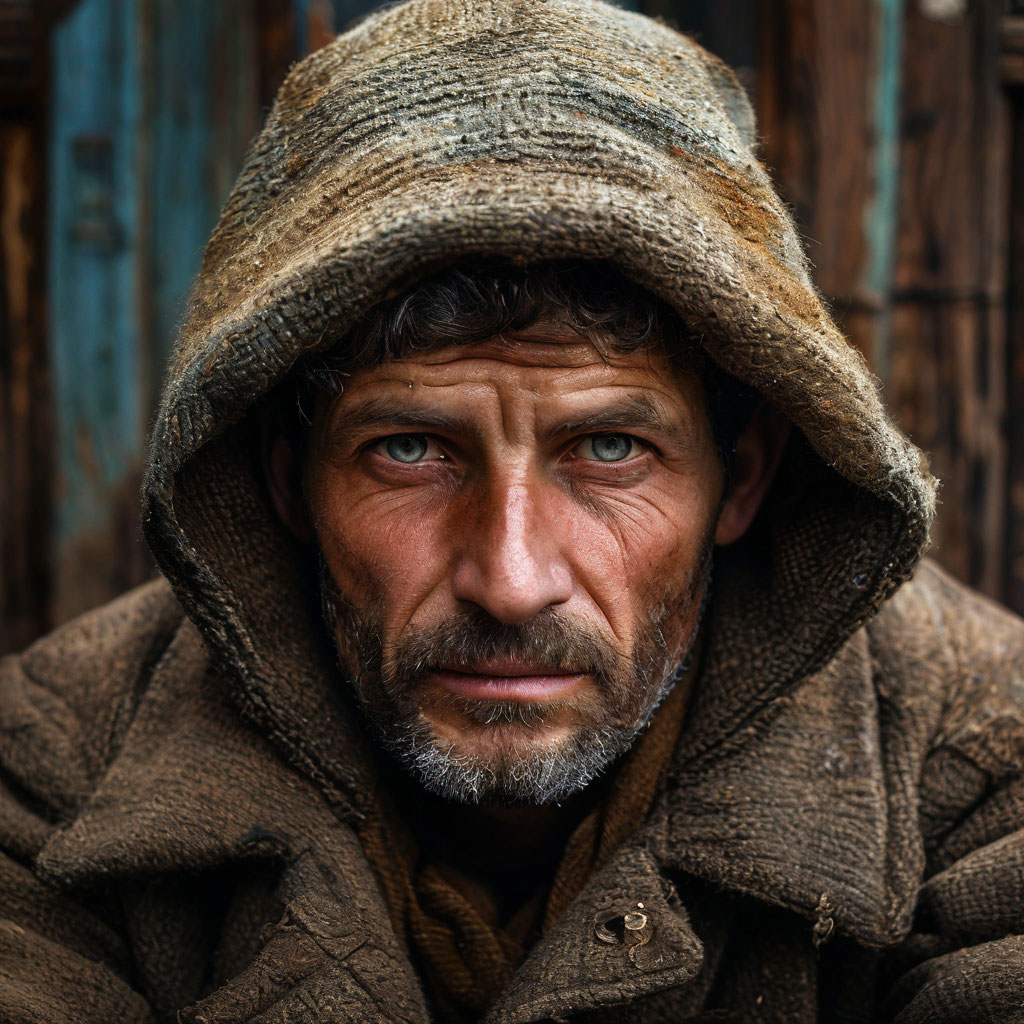

In [ ]:
import io
from PIL import Image
import base64

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None

check(id)

Видим, что получилось не очень :( Чтобы улучшить результат, попробуем создать двух персонажей, чтобы они обсуждали промпт друг с другом, как в примере выше:

In [ ]:
import time

topic = "бедность"

vasya_desc="""
Ты - художник, который хочет нарисовать картину с помощью генеративного ИИ. Ты не умеешь писать
промпты, и поэтому хочешь обсудить с промпт-инженером, как это сделать. Ваша задача - совместными
усилиями нарисовать картину на про {}. Твоя задача - говорить, что должно быть
изображено на картине, но не надо писать промпт для нейросети - просто говори, что бы ты хотел
видеть.
""".format(topic)

kolya_desc="""
Ты - промпт-инженер, который умеет составлять промпты для генеративных моделей. Твоя задача - помочь
художнику нарисовать картину. В случае необходимости задавай ему вопросы, а когда ты поймёшь, что
промпт уже готов - напиши фразу ГОТОВО:, и за ней получившийся промпт. Не пиши промпт и фразу "ГОТОВО",
если ты не выяснишь все детали у художника. Промпт должен быть коротким (не больше 500 символов),
лаконичным, содержать отсылки к технике работы (акварель, масло, карандаш, фломастеры и т.д), и
возможно к художественным стилям и приёмам.
"""

vasya = ABot(GPT,vasya_desc)
kolya = ABot(GPT,kolya_desc)

msg = f"Добрый день! Я хочу нарисовать картину про {topic}. Вы поможете мне составить промпт?"

for _ in range(4):
    print(f"Вася: {msg}")
    msg = kolya(msg)
    print(f"Коля: {msg}")
    # if "ГОТОВО:" in msg.upper():
    #    break
    time.sleep(1)
    msg = vasya(msg)
    time.sleep(1)


Вася: Добрый день! Я хочу нарисовать картину про бедность. Вы поможете мне составить промпт?
Коля: Здравствуйте! Опишите, пожалуйста, какие детали вы хотели бы отразить в картине про бедность? Предлагаю нарисовать акварелью группу людей, сидящих за пустым столом. ГОТОВО: «Нарисуй акварелью группу людей, сидящих за пустым столом».
Вася: Здравствуйте! Да, группа людей за пустым столом — хорошая идея. Пусть это будет семья: родители и дети. Они выглядят уставшими и грустными, но всё равно держатся вместе. На столе ничего нет, кроме нескольких пустых чашек. Одежда на людях старая и поношенная, видны следы штопки.
Коля: Здравствуйте! Спасибо за подробности. Предлагаю такой промпт: «Нарисуй акварелью сцену из жизни бедной семьи: родители и дети сидят за пустым столом, на котором несколько пустых чашек. Одежда на людях старая и поношенная, видны следы штопки. Все выглядят уставшими и грустными, но всё равно держатся вместе». ГОТОВО: «Нарисуй акварелью сцену из жизни бедной семьи: родители и д

Выделяем получившийся промпт:

In [ ]:
# prompt = msg.split('ГОТОВО:')[1]
prompt = "Нарисуй акварелью сцену из жизни бедной семьи: родители и дети сидят за пустым столом, на котором несколько пустых чашек. Одежда на людях старая и поношенная, видны следы штопки. Все выглядят уставшими и грустными, но всё равно держатся вместе. Обстановка вокруг скромная, но чистая. За окном видно серое небо и голые деревья. Над столом висит полка с книгами"

Рисуем:

In [ ]:
id = submit_art(prompt)

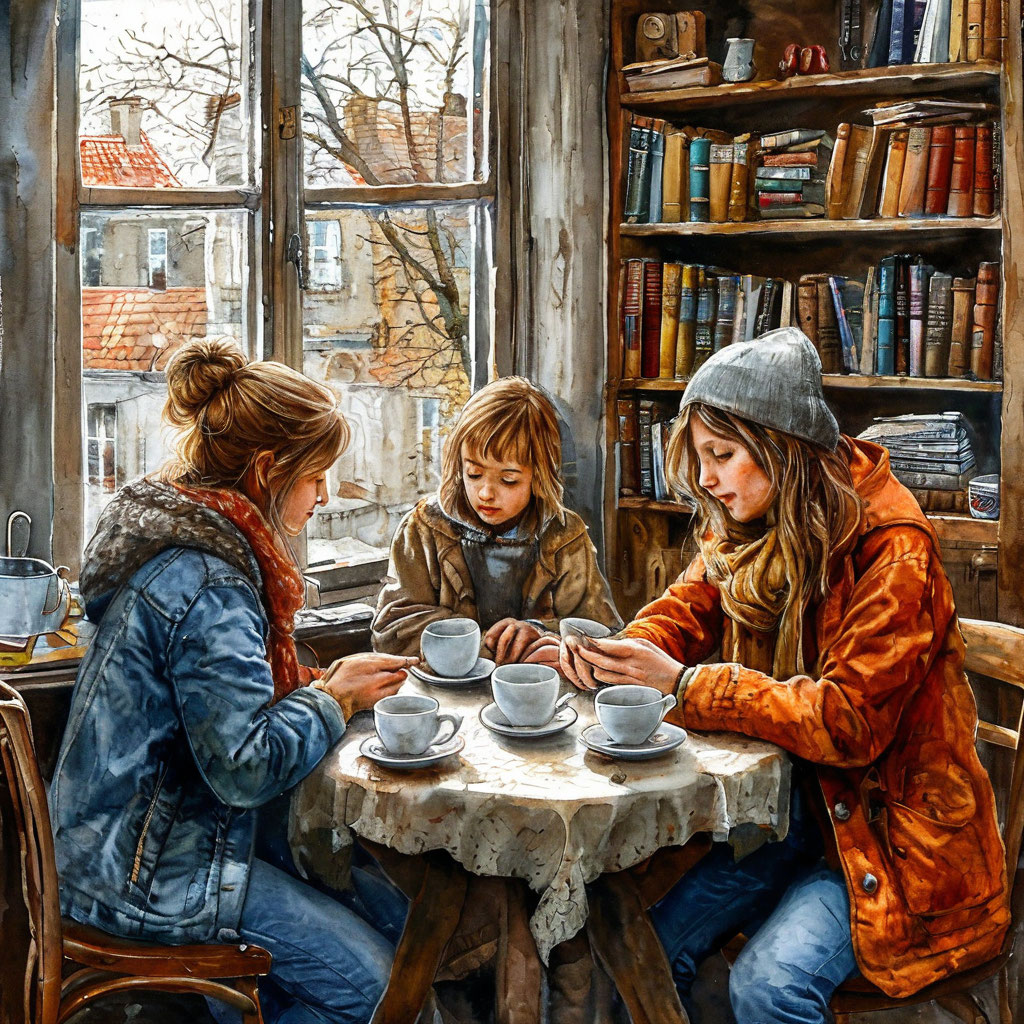

In [ ]:
check(id)

## Мораль

Нейросети могут эффективно использоваться для работы с текстом. Классические модели решают конкретные задачи, вроде определения тональности, машинного перевода или извлечения сущностей, в то время как фундаментальные (большие языковые) модели могут выполнять множество функций, но существенно медленнее и дороже в использовании.

Запускать фундаментальные модели можно:
* В облаке (за деньги, но быстро и просто)
* На GPU (в т.ч. в Colab) с помощью серверов вроде ollama или vLLM
* На GPU прямо внутри Colab

Во всех случаях общение с моделью происходит единообразно.